## **概要**

AlphaZeroのアルゴリズムは以下のような手順で構成される：

1. 自己対戦による学習: AlphaZeroは、自分自身と対戦しながら学習する。ランダムな手法からスタートし、強化学習アルゴリズムを用いて次第に強くなる。

2. モンテカルロ木探索: AlphaZeroは、モンテカルロ木探索（MCTS）を使用してゲームのツリーを探索する。これにより、最適な手を見つけるために局面を評価し、次の手を決定する。

3. ニューラルネットワーク: AlphaZeroは、ゲームの状態を評価するためのニューラルネットワークを使用する。このニューラルネットワークは、ゲームの局面を入力とし、局面の価値を出力する。価値は、勝率や局面の良さなどを示す。

4. 強化学習: AlphaZeroは、報酬を最大化するようにニューラルネットワークを調整することで学習します。報酬は、ゲームの勝利や敗北などによって与えられます。

### **ライブラリ**

In [1]:
import numpy as np
import math
# pytorchのライブラリをインポート
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# 対戦状況を可視化するためのライブラリをインポート
from IPython.display import clear_output
import time

trans = torchvision.transforms.ToTensor()  # データをpytorchのテンソルに変換する関数

## **オセロのルールを反映させたクラス**

In [ ]:
# オセロの状態を表すクラス(構造体)
# 8x8の盤面を持ち、各マスには黒か白か空かのいずれかが入る
# 盤面の状態を配列で表現する
class Board():
    # 8x8の配列を初期化する
    def __init__(self):
        self.board = [[0 for i in range(8)] for j in range(8)]
        self.board[3][3] = 1    # 白(◯)
        self.board[4][4] = 1    # 白
        self.board[3][4] = -1    # 黒(×)
        self.board[4][3] = -1    # 黒
        self.player = -1         # 黒が先手
    # 盤面の配列を取得する
    def getBoard(self):
        return self.board
    # 盤面の配列をベクトルとして取得する
    def getBoardVec(self):
        return np.array(self.board).reshape(64).tolist()
    # 盤面の状態を表示する
    def show(self):
        for row in self.board:
            print("|", end="")
            for cell in row:
                if cell == 0:
                    print(" ", end="")  # end="" で改行しない
                elif cell == 1:
                    print("o", end="")
                elif cell == -1:
                    print("x", end="")
            print("|")                     # 一行表示して改行
        print("player: o") if self.player == 1 else print("player: x")
    # ファイルに盤面の状態を書き込む
    def fshow(self, filename):
        with open(filename, "a") as f:
            for row in self.board:
                f.write("|")
                for cell in row:
                    if cell == 0:
                        f.write(" ")
                    elif cell == 1:
                        f.write("o")
                    elif cell == -1:
                        f.write("x")
                    # f.write(str(cell))
                f.write("|\n")
            if self.player == 1:
                f.write("player: o")
            else:
                f.write("player: x")
    # 置く場所が盤面上にあるか判定する
    def outofBoard(self, x, y):
        return x < 0 or x >= 8 or y < 0 or y >= 8
    # (x, y)に石を置くとき、(dx, dy)方向にひっくり返す石があるか判定する
    def canPutDir(self, x, y, dx, dy):
        i = 1
        if self.outofBoard(x + dx, y + dy):
            return False
        else:
            while self.board[y + dy * i][x + dx * i] == -(self.player):    # 相手の石が続く限り
                i += 1
                if self.outofBoard(x + dx * i, y + dy * i):                 # 盤面外に出たら
                    return False
                elif self.board[y + dy * i][x + dx * i] == 0:               # 石がない場所があれば
                    return False
                elif self.board[y + dy * i][x + dx * i] == self.player:     # 自分の石で挟めるなら
                    return True
    # (x, y)に石を置けるか判定する
    def canPut(self, x, y):
        if not self.outofBoard(x,y) and self.board[y][x] != 0:                                           # すでに石が置かれている
            return False
        # 周囲8方向を調べる; 1方向でもひっくり返せるなら置ける
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                if dx == 0 and dy == 0: 
                    continue
                if self.canPutDir(x, y, dx, dy):                             # (dx, dy)方向にひっくり返せる石がある
                    return True
        return False
    # (x, y)に石を置いたときの盤面クラスを返す
    def put(self, x, y):
        newBoard = Board()
        newBoard.board = [row[:] for row in self.board] # 盤面をコピー
        newBoard.player = -self.player   # プレイヤーを交代
        newBoard.board[y][x] = self.player  # 石を置く
        # ひっくり返せる石を全てひっくり返す
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                if dx == 0 and dy == 0:
                    continue
                if self.canPutDir(x, y, dx, dy):
                    i = 1
                    while newBoard.board[y + dy * i][x + dx * i] == -self.player:
                        newBoard.board[y + dy * i][x + dx * i] = self.player    # 石をひっくり返す
                        i += 1
        return newBoard
    # 石を置ける場所があるか判定する
    def canPlay(self):
        for y in range(8):
            for x in range(8):
                if self.canPut(x, y):
                    return True
        return False
    # 石を置ける場所と置いた場合の盤面クラスを辞書型で返す
    def choices(self):          # 動的計画法において、for choice in board.choices(): で呼び出す
        choices = {}
        for y in range(8):
            for x in range(8):
                if self.canPut(x, y):
                    choices[(x, y)] = self.put(x, y)
        return choices
    # 石を置ける場所がなく場合にプレイヤーを交代するか判定し、交代する (交代する場合は新たな盤面を返す)
    def passPlayer(self):   # Board.passPlayer()で呼び出す
        if not self.canPlay():
            # 新たな盤面を作成し、プレイヤーを交代する
            newBoard = Board()
            newBoard.board = [row[:] for row in self.board] # 盤面をコピー
            newBoard.player = -self.player
            return newBoard
        else:
            return self
    # 盤面が等しいか判定する
    def isEq(self, other):
        return self.board == other.board and self.player == other.player
    # 盤面を比較し、打った手を返す
    def diff(self, other):
        for y in range(8):
            for x in range(8):
                if self.board[y][x] != other.board[y][x]:
                    return (x, y)
        return None
    # 勝負がついたか判定する
    def isEnd(self):
        if not self.canPlay() and not self.passPlayer().canPlay():
            # print("Game Over")
            # self.winner()
            return True
        else:
            return False
    # 石の数を数え、勝敗を判定する
    def counter(self, num):
        tot = 0
        for row in self.board:
            for cell in row:
                if cell == num:
                    tot += 1
        return tot
    # 勝者を返す
    def winner(self):
        if not self.isEnd():
            return
        # print("Game Over")
        black = self.counter(-1)
        white = self.counter(1)
        if black > white:
            # print("Black(×) wins!")
            return -1
        elif black < white:
            # print("White(◯) wins!")
            return 1
        else:
            # print("Draw")
            return 0

### **実際に人間同士でプレイしてみる**

In [3]:
def playHtoH(filename):
    # ゲームをプレイする
    board = Board()
    # ログファイルを初期化
    with open(filename, "w") as f:
        f.write(time.strftime("%Y/%m/%d %H:%M") + "\n")
        f.close()
    x, y = 0, 0
    while not board.isEnd():
        time.sleep(1.0)                                     # 0.5秒待つ
        clear_output()                                      # 画面をクリア
        board.show()                                        # 盤面を表示
        board.fshow(filename)                            # 盤面をファイルに書き込む
        if board.canPlay():
            print("Put coordinate x, y: ", end="")
            x, y = map(int, input().split())                # 入力を受け取る
            print("(", x, ", ", y,")")                      # 入力を表示
            if board.canPut(x, y):
                board = board.put(x, y)
            else:
                print("Can't put")
        else:
            board = board.passPlayer()                      # 石を置けない場合はプレイヤーを交代
    time.sleep(1.0)
    clear_output()
    board.show()
    board.fshow(filename)
    board.winner()

In [23]:
playHtoH("log/demoPlay_00.txt")

|        |
|   o    |
|   oo   |
| ooooo  |
|   ooo  |
|   ooo  |
|        |
|        |
player: x


## **探索アルゴリズム**

**Monte-Carlo-Tree-Search(MCTS)**による学習アルゴリズムを実装する。

### **MCTSのアルゴリズム**

参考文献：[Monte Carlo Tree Search - Wikipedia](https://en.wikipedia.org/wiki/Monte_Carlo_tree_search)

モンテカルロ木探索は4つのステップからなる。

Nodeは、ゲームの状態を表し、プレイアウトの回数と勝利の回数を保持している。

1. 選択：Root Node から始めて、Leaf Node にたどり着くまで、子ノードを選択し続ける。Root Node が現在のゲームの状態で、Leaf Node はシミュレーションが行われていないノード。より有望な方向に木が展開していくように、子ノードの選択を片寄らせる方法を採用するため、以下の Alpha Zero 指標を用いる。
2. 展開：Leaf Node が勝負を決するノードでない限り、Leaf Node から有効手の子ノードの中から Child Node を1つ選ぶ。
3. シミュレーション：Child Node からプレイアウトを行う。Alpha Zero 指標に基づいてプレイアウトを実行する。
4. バックプロパゲーション：Child Node から Root Node へのパスに沿って、プレイアウトの結果を伝搬する。

### **Alpha Zero 指標**

Alpha Zero 指標は、探索と活用のバランスを取る指標である。

$ Q(s, a) + U(s, a) $

が最大となる行動を選択する。ここで、$Q(s, a)$ は状態 $s$ で行動 $a$ を取った時の行動価値関数 $(=V(s'))$、$U(s, a)$ は探索項である。

$ U(s, a) = c(s) P(s, a) \frac{\sqrt{\sum_{b} N(s, b)}}{1 + N(s, a)} $

ここで、$c(s)$ は下記の式で定まる数で、$P(s, a)$ は方策ネットワークによる行動 $a$ の選択確率、$N(s, a)$ は状態 $s$ で行動 $a$ を選択した回数、$\sum_{b} N(s, b)$ は状態 $s$ に到達した回数である。

$ c(s) = c_{init} + \log{\frac{1 + N(s) + c_{base}}{c_{base}}} $

ここで、$c_{base}$ はハイパーパラメータであり、$N(s)$ は状態 $s$ に到達した回数である。

### **Q関数の更新**

チェスは、遷移確率が one-hot つまり $P(s'|s,a)=1$ であるため、状態価値関数 $V(s)$ と行動価値関数 $Q(s, a)$ は同じものとして扱うことができる。したがって、
盤面の状態を64次元のベクトル(とる値は ${-1,0,1}$ )で表現し、それに対して有利不利を $[-1,1]$ の範囲で出力する状態行動価値関数 $Q(s,a)=V(s')$ を学習する。

## **MCT Node クラスの実装**

In [83]:
# Monte-Carlo Tree のノードを表すクラス
class MCTSNode:
    def __init__(self, board):
        self.board = board          # Boardクラス
        self.parent = None          # 親ノード
        self.children = []          # 子ノード
        self.visits = 0             # ノードを訪れた回数
        self.score = 0              # ノードの評価値
    # ノードの展開(子ノードを追加)
    def expand(self):
        if self.board.isEnd():          # ゲーム終了時は展開しない
            return
        elif len(self.children) > 0:    # 既に展開済みの場合は展開しない
            return
        else:
            choices = self.board.choices()              # 石を置ける場所と置いた場合の盤面クラスを取得(Boardクラスのchoicesメソッド)
            for choice, board in choices.items():       # 石を置ける場所全てについて、子ノードに追加
                node = MCTSNode(board)
                node.parent = self
                self.children.append(node)
    # 子ノードの選択確率を計算し、石を置いた場所にその確率を当てはめた二次元配列を返す
    def probabilities(self, flag):
        probs = [[0 for i in range(8)] for j in range(8)]
        choices = self.board.choices()
        for child in self.children:
            for x, y in choices:    # 石を置いた場所を取得
                # print(key, board)     # デバグ用
                board = choices[(x, y)]
                if child.board.isEq(board):             # 石を置いた場所が等しい場合
                    probs[y][x] = child.visits/self.visits
        # 確率の合計がほぼ1であることを確認し、あまりにも差がある場合には、エラーを出力
        v = sum([sum(prob) for prob in probs])
        if abs(v-1) > 0.01 and abs(v) > 0.01:
            print("Error: sum(prob) != 1")
            print(np.array(probs).reshape(64).tolist())
        # 二次元配列を返すか、フラグが立っている場合は一次元配列に変換して返す
        if flag==True:
            return np.array(probs).reshape(64).tolist()
        else:
            return probs

### **AlphaZero 指標の計算関数**

In [84]:
# mctsNodeで、choiceを選択することの評価値(行動価値関数と探索項の和)を返す
def alpha_zero_score(mctsNode, key, mcTree, policy, Q_value, flag=True):
    # ハイパーパラメータ
    c_base = 1000
    c_init = 1.25
    # 行動価値関数の値を計算
    value = Q_value.predict(mctsNode.board, key)
    # ノードの探索項を計算
    N = mctsNode.visits                                 # mctsNodeを訪れた回数
    childNode = mcTree.move_cop(key)                    # keyの手を打ったときのノードを取得
    Nc = childNode.visits                               # mctsNodeからchoiceを選択した回数
    C = c_init + np.log((N + c_base + 1) / c_base)      # ノードの訪問回数で決まる係数
    x, y = key                                          # keyの手を打った場所
    exploration = C * np.sqrt(N) / (1 + Nc) * policy.predict(mctsNode.board)[y][x]          # 探索項
    if flag:
        # ノードの評価値と探索項の和を返す
        return value + exploration
    else:
        return value

## **MC Tree クラスの実装**

In [85]:
# Monte-Carlo Tree のクラス
class MCTree:
    def __init__(self, board):
        self.root = MCTSNode(board)                 # ルートノードを作成
        self.current = self.root                    # 現在のノード
    # ノードの選択(flag=True: 探索を行う, flag=False: 探索を行わない)
    def select(self, Policy, Q_value, flag=True):
        node = self.current
        choices = self.current.board.choices()              # 石を置ける場所と置いた場合の盤面を取得
        # alpha_zero_score()を用いて、評価値が最大の子ノードを選択
        max_score = -math.inf
        for choice, board in choices.items():
            # time.sleep(1.0)    # 0.5秒待つ
            # clear_output()    # 画面をクリア
            # print("choice: player is", board.player)    # デバグ用
            # board.show()    # デバグ用
            for child in node.children:
                # time.sleep(1.0)    # 0.5秒待つ
                # clear_output()    # 画面をクリア
                # print("child: player is", child.board.player)    # デバグ用
                # child.board.show()    # デバグ用
                if child.board.isEq(board):
                    # print("I found child node\n")    # デバグ用
                    score = alpha_zero_score(node, choice, self, Policy, Q_value, flag)
                    if score > max_score:
                        max_score = score
                        node = child
        # time.sleep(1.0)    # 0.5秒待つ
        # clear_output()    # 画面をクリア
        #print("I choose: ")    # デバグ用
        #node.board.show()    # デバグ用
        return node
    # ノードの移動(クラスをコピーせず、現在のノードを変更する)
    def move_cur(self, key):                        # key: 石を置く場所を指定
        # 現在のノードに対して、keyに石を置いた場合の盤面を辞書のキーから検索
        choices = self.current.board.choices()              # 石を置ける場所と置いた場合の盤面を取得
        for choice, board in choices.items():
            if choice == key:                               # keyに石を置いた場合の盤面クラスを子ノードから見つけたら
                for child in self.current.children:
                    if child.board.isEq(board):                # 盤面クラスの一致を確認
                        self.current = child
                        return
    # ノードの移動(クラスをコピーして、現在のノードを変更する)
    def move_cop(self, key):                       # key: 石を置く場所を指定
        # 現在のノードに対して、keyに石を置いた場合の盤面を辞書のキーから検索
        choices = self.current.board.choices()              # 石を置ける場所と置いた場合の盤面を取得
        for choice, board in choices.items():
            if choice == key:                               # keyに石を置いた場合の盤面クラスを子ノードから見つけたら
                for child in self.current.children:
                    if child.board.isEq(board):                # 盤面クラスの一致を確認
                        self.current = child
                        return child

## **自己対戦クラスの実装**

プレイヤークラスのメソッドは以下の通りです。

#### **MC Tree の初期化**

#### **経験の獲得**

今回は、行動毎に報酬を得るわけではなく、１ゲームをプレーした後に報酬を得ることに注意が必要である。さらには、バッチサイズ分ゲームをプレーして、それに対する

#### **MC Tree の更新**

実際のプレイヤーの行動とそれに対する報酬(勝利:1, 敗北:-1, 引き分け:0)を受け取り、MC Tree に追加します。

#### **状態行動価値関数の初期化**

状態行動価値関数 $Q_{\theta}(s_t, a_t)$ について、初期化する。

#### **方策の更新**

基本的には、マルチステップ方策評価・マルチステップ方策更新を行う。その際には、Greedy Policy とするか、$\epsilon$-Greedy Policy 、あるいは Softmax Policy とするかを指定する。

#### **行動の選択**
自分のターンが来たら、方策に従って行動を選択する。決定論的な方策を取るか、確率的な方策を取るかは、方策の種類次第になる。

### **データセットクラスの実装**

In [86]:
class MyDataset(Dataset):
    def __init__(self, xs, ys, zs): # xs: 盤面の状態が並んだリスト, ys: 方策が並んだリスト, zs: 報酬が並んだリスト
        self.input = xs
        self.target_prob = ys
        self.target_rew = zs
    def __len__(self):
        return len(self.input)
    def __getitem__(self, idx):
        # 盤面の状態を、in_channels=1, 8x8のテンソルに変換
        input = torch.tensor(self.input[idx], dtype = torch.float32)
        input = input.unsqueeze(0)
        # 方策を、長さ64の一次元テンソルに変換
        target_prob = torch.tensor(self.target_prob[idx], dtype = torch.float32)
        # 報酬を、スカラー値に変換
        target_rew = torch.tensor(self.target_rew[idx], dtype = torch.float32)
        return input, target_prob, target_rew
    
# dataset = MyDataset(xs, ys, zs)   # データセットを作成
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)   # データローダーを作成
# for inputs, target1s, target2s in dataloader:  # データローダーからミニバッチを取り出す

In [134]:
class Player:
    def __init__(self, Policy, Q_value):
        self.Policy = Policy            # 方策NN
        self.Q_value = Q_value          # 行動価値NN            
        self.path = [[]]                # プレイしたノード(MCTSNodeクラス)の履歴
        self.nodes = []                 # ミニバッチ全体で一度でもプレイしたノード(MCTSNodeクラス)のリスト
        self.cursor = 0                 # ミニバッチにおける現在のインデックス
        self.reward = [0,0]             # [黒の報酬、白の報酬](勝利: 1, 引き分け: 0.5, 敗北: 0)
    # 1手プレイする
    def oneplay(self, mctree, flag=True):
        # モンテカルロ木探索
        if len(mctree.current.children)==0:             # 子ノードがない場合は展開
            mctree.current.expand()
            if len(mctree.current.children)==0:         # 打てる手がない場合はパス
                mctree.current.board = mctree.current.board.passPlayer()
                return mctree
        ans = mctree.select(self.Policy, self.Q_value, flag)  # ノードの選択
        # time.sleep(1.0)                                 # 0.5秒待つ
        # clear_output()                   
        #                # 画面をクリア
        # print("selected:")
        # ans.board.show()                                # 盤面を表示(デバッグ用)
        mctree.current = ans    # ノードの選択と現ノードの変更
        # time.sleep(0.2)                                     # 0.5秒待つ
        # clear_output()                                      # 画面をクリア
        # mctree.current.board.show()                                 # 盤面を表示(デバッグ用)
        self.path[self.cursor].append(mctree.current)                # 選択したノードを記録
        # self.nodesに進んだ先のノードがなければ追加
        if mctree.current not in self.nodes:
            self.nodes.append(mctree.current)
        return mctree
    # 1ゲーム自己対戦する
    def play1game(self, mctree):
        board = Board()
        while not mctree.current.board.isEnd():
            mctree = self.oneplay(mctree)
            #mctree.current.board.show()
            # print("p",end="")
        board = mctree.current.board
        board.show()
        if board.winner() == -1:
            self.reward[0] += 1
        elif board.winner() == 1:
            self.reward[1] += 1
        else:
            self.reward[0] += 0.5
            self.reward[1] += 0.5
    # プレイしたノードの訪問回数と評価値を更新する
    def backup(self):
        for node in self.path[self.cursor]:                  # プレイしたノード全てについて
            node.visits += 1
            if node.board.player == 1:          # そのノードでプレイしたのが黒の場合
                node.score += self.reward[0]
            else:                               # そのノードでプレイしたのが白の場合
                node.score += self.reward[1]
            # print("b",end="")
    # モンテカルロ・シミュレーションのサンプルサイズ分、1ゲーム自己対戦・backupする
    def play1batch(self, mctree, sample_size):
        for i in range(sample_size):
            k = 1
            if sample_size > 2:
                k = sample_size // 2
            if i % k == 0:
                print("game", i)
            self.play1game(mctree)
            self.backup()
            if i != sample_size - 1:
                self.cursor += 1
                self.path.append([])
    # self.nodesを、visit回数の降順にソートする
    def sort_nodes(self):
        self.nodes.sort(key=lambda x: x.visits, reverse=True)
    # データをロードする(盤面、手の選択確率、報酬)
    def prepare(self, batch_size):
        # データセットをリストで作成
        xs = []  # 盤面の状態(入力)
        ys = []  # 方策(出力)
        zs = []  # 報酬
        for node in self.nodes:
            x_item = node.board.getBoard()
            # 盤面の状態をndarray型に変換し、全ての要素を+1して、float型に変換
            x_item = np.array(x_item)           # ndarray型に変換
            if node.board.player == -1:
                x_item = x_item * (-1)
            x_item = x_item + 1
            x_item.tolist()                     # リストに変換
            xs.append(x_item)
            # 教師信号は、mcTreeにおいて、選択されたノードに対する、子ノードの選択確率(ここでは、石を置いた場所に確率を割り当てた64次元のベクトル)
            ys.append(node.probabilities(True))
            # 報酬は、ノードの評価値を割り当てる
            zs.append(node.score/node.visits)
        dataset = MyDataset(xs, ys, zs)   # pytorchに利用可能な形で、データセットを作成
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)  # データローダーを作成
        return dataloader
    def fshow(self, filename):
        # 盤面をファイルに書き込む
        idx = 0
        for path in self.path:
            if len(path) > 0:
                with open(filename, "a") as f:
                    f.write("---------<< path #")
                    f.write(str(idx))
                    f.write(" >>-----------\n")
                    f.close()
                path[-1].board.fshow(filename)
            idx += 1

## **方策ネットワーククラスの実装**

In [130]:
class p_net(nn.Module):
    def __init__(self):
        super().__init__()  # 親クラスのnn.Moduleを呼び出し
        self.features = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1, padding_mode='replicate'),    # out_channelsは欲しい特徴マップの数
            nn.ReLU(),
            nn.Conv2d(4, 16, kernel_size=3, padding=1, padding_mode='replicate'),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1, padding_mode='replicate'),
            nn.ReLU(),
            nn.Conv2d(16, 4, kernel_size=3, padding=1, padding_mode='replicate'),
            nn.ReLU(),
            nn.Conv2d(4, 1, kernel_size=1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64, 64),              # 全結合層
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.Softmax(dim=1)               # ミニバッチの各データセットごとに確率分布に変換
        )
    # 盤面の状態を入力として、方策を返す
    def forward(self, input):
        hidden = self.features(input)
        hidden = hidden.view(hidden.size(0),-1)  # x.size(0)は例えばnum_batches
        output = self.classifier(hidden)         # 64次元のベクトルとして方策を返す
        return output
    # 実際の石の置き場所と方策との交差エントロピー誤差を損失関数とする
    def backprop(self, output, optimizer, criterion, target):
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        # return loss(output, target)
    # 盤面を入力したときの、方策を計算する関数
    # ネットワークは、ミニバッチ学習用に設計されているため、1つのデータセットを入力する場合には、空のデータセットを追加する
    def predict(self, board):
        # 盤面の状態をndarray型に変換し、全ての要素を+1して、float型に変換
        x = board.getBoard()
        x = np.array(x, dtype=np.float32)           # ndarray型に変換
        if board.player == -1:
            x = x * (-1)
        x = x + 1
        x = trans(x)
        pred = self.forward(x)
        # predを8x8の配列に変換
        return pred.view(8,8)

## **価値ネットワーククラスの実装**

In [131]:
class v_net(nn.Module):
    def __init__(self):
        super(v_net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=7, padding=3, padding_mode='replicate'),
            nn.ReLU(),
            nn.Conv2d(4, 16, kernel_size=5, padding=2, padding_mode='replicate'),
            nn.ReLU(),
            nn.Conv2d(16, 4, kernel_size=3, padding=1, padding_mode='replicate'),
            nn.ReLU(),
            nn.Conv2d(4, 1, kernel_size=1)
        )
        self.value = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Tanh()
        )
    # 順伝播 
    def forward(self, input):
        hidden = self.features(input)
        hidden = hidden.view(hidden.size(0),-1)
        output = self.value(hidden)
        return output
    # 実際の勝率と勝率の予測値との二乗誤差を損失関数とする
    def backprop(self, output, optimizer, criterion, target):
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        return loss
    # 盤面を入力したときの、勝率を予測する関数
    def predict(self, board, key):
        # 盤面の状態をndarray型に変換し、全ての要素を+1して、float型に変換
        x = board.put(key[1],key[0]).getBoard()         # key[1]: y, key[0]: x に石を置いた盤面を取得
        x = np.array(x, dtype=np.float32)                                 # ndarray型に変換
        if board.player == -1:
            x = x * (-1)
        x = x + 1
        input = trans(x)
        # 予測値を計算
        pred = self.forward(input)
        return pred

## **学習の一例**

### **自己対戦アルゴリズムの確認**

In [132]:
# ネットワークの初期化
policy = p_net()             # 方策NNを作成
Q_value = v_net()            # 行動価値NNを作成

# 対戦の準備
board = Board()             # 盤面を初期化
mctree = MCTree(board)      # モンテカルロ探索木を初期化

# 自己対戦プレイヤーを作成
player = Player(policy, Q_value)      
player.play1batch(mctree, 1)  # サンプルサイズ分、自己対戦を行い、学習する
# print(mctree)
# print(player)

game 0
|        |
|        |
|   x    |
|   xx   |
|   xo   |
|        |
|        |
|        |
player: o
|        |
|        |
|  ox    |
|   ox   |
|   xo   |
|        |
|        |
|        |
player: x
|        |
|        |
| xxx    |
|   ox   |
|   xo   |
|        |
|        |
|        |
player: o
|        |
| o      |
| xox    |
|   ox   |
|   xo   |
|        |
|        |
|        |
player: x
| x      |
| x      |
| xox    |
|   ox   |
|   xo   |
|        |
|        |
|        |
player: o
|ox      |
| o      |
| xox    |
|   ox   |
|   xo   |
|        |
|        |
|        |
player: x
|ox      |
| o      |
| xox    |
|  xxx   |
|   xo   |
|        |
|        |
|        |
player: o
|ooo     |
| o      |
| xox    |
|  xxx   |
|   xo   |
|        |
|        |
|        |
player: x
|ooo     |
| ox     |
| xxx    |
|  xxx   |
|   xo   |
|        |
|        |
|        |
player: o
|ooo     |
| ooo    |
| xxx    |
|  xxx   |
|   xo   |
|        |
|        |
|        |
player: x
|ooox    |
| 

### **学習も含めた実行例**

In [135]:
# ネットワークの初期化
policy = p_net()             # 方策NNを作成
# policy.load_state_dict(torch.load('bin/policy.pth'))
Q_value = v_net()            # 行動価値NNを作成
# Q_value.load_state_dict(torch.load('bin/Q_value.pth'))

# オプティマイザ、エポック数、バッチサイズ、モンテカルロ・シミュレーションのサンプルサイズを設定
policy_optimizer = optim.Adam(policy.parameters(), lr = 0.001, weight_decay = 5e-4)
Q_value_optimizer = optim.Adam(Q_value.parameters(), lr = 0.001, weight_decay = 5e-4)
policy_criterion = nn.CrossEntropyLoss()
Q_value_criterion = nn.MSELoss()
num_epochs = 10
sample_size = 20000                               # サンプルサイズ(モンテカルロ・シミュレーションで確率分布を求めるためのサンプル数)  *スケジューリングで変更したい
batch_size = int(sample_size/10)                # バッチサイズ

# 記録先を指定
log_filename = "log/train_"+ time.strftime("%Y%m%d%H%M") + ".txt"
# ファイルを初期化
with open(log_filename, "w") as f:
    f.write(time.strftime("%Y/%m/%d %H:%M") + "\n")
    f.close()

time_limit = 1800                         # 学習時間の上限(秒)
start_time = time.time()                        # ループの開始時刻を取得

learn_count = 0
while True:
    ############### 学習の1ループ開始
    # learn_count がきりのいい数になったら、それを表示
    if learn_count % 10 == 0:
        print("===== learn #",learn_count)
    # 対戦の準備
    board = Board()             # 盤面を初期化
    mctree = MCTree(board)      # モンテカルロ探索木を初期化

    # 自己対戦プレイヤーを作成
    player = Player(policy, Q_value)      
    player.play1batch(mctree, sample_size)  # サンプルサイズ分、自己対戦を行い、学習する
    player.fshow(log_filename)
    # player.sort_nodes()         # プレイしたノードを訪問回数の降順にソート

    # ミニバッチに分割されたデータを作成
    dataloader = player.prepare(batch_size) 

    # ミニバッチ学習
    for inputs, policy_targets, reward_targets in dataloader:
        # print(input.size())
        # print(policy_target.size())
        # print(reward_target.size())
        # 勾配バッファの初期化
        policy_optimizer.zero_grad()
        Q_value_optimizer.zero_grad()
        # 順伝播
        policy_output = policy.forward(inputs)
        reward_output = Q_value.forward(inputs)
        # 逆伝播
        policy.backprop(policy_output, policy_optimizer, policy_criterion, policy_targets)
        Q_value.backprop(reward_output, Q_value_optimizer, Q_value_criterion, reward_targets)
    
    # 学習時間の計測
    if time.time() - start_time > time_limit:
        break
    break
    
    learn_count += 1
    ############### 学習の1ループ終了

# モデルの保存
torch.save(policy.features.state_dict(), 'bin/policy2.pth')
torch.save(policy.state_dict(), 'bin/policy2_sim.pth')
torch.save(Q_value.state_dict(), 'bin/Q_value2_sim.pth')
torch.save(Q_value.features.state_dict(), 'bin/Q_value2.pth')

===== learn # 0
game 0
|ooooooox|
|ooooooxx|
|oooooxox|
|ooooxoox|
|ooooooox|
|oooxooox|
|ooooxxox|
|xxxxxxoo|
player: x
|ooooooox|
|ooooooxx|
|oooooxox|
|ooooxoox|
|ooooooox|
|oooxooox|
|ooooxxox|
|xxxxxxoo|
player: x
|ooooooox|
|ooooooxx|
|oooooxox|
|ooooxoox|
|ooooooox|
|oooxooox|
|ooooxxox|
|xxxxxxoo|
player: x
|ooooooox|
|ooooooxx|
|oooooxox|
|ooooxoox|
|ooooooox|
|oooxooox|
|ooooxxox|
|xxxxxxoo|
player: x
|ooooooox|
|ooooooxx|
|oooooxox|
|ooooxoox|
|ooooooox|
|oooxooox|
|ooooxxox|
|xxxxxxoo|
player: x
|ooooooox|
|ooooooxx|
|oooooxox|
|ooooxoox|
|ooooooox|
|oooxooox|
|ooooxxox|
|xxxxxxoo|
player: x
|ooooooox|
|ooooooxx|
|oooooxox|
|ooooxoox|
|ooooooox|
|oooxooox|
|ooooxxox|
|xxxxxxoo|
player: x
|ooooooox|
|ooooooxx|
|oooooxox|
|ooooxoox|
|ooooooox|
|oooxooox|
|ooooxxox|
|xxxxxxoo|
player: x
|ooooooox|
|ooooooxx|
|oooooxox|
|ooooxoox|
|ooooooox|
|oooxooox|
|ooooxxox|
|xxxxxxoo|
player: x
|ooooooox|
|ooooooxx|
|oooooxox|
|ooooxoox|
|ooooooox|
|oooxooox|
|ooooxxox|
|xxxxxxoo|
player:

c:\Users\ryota\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


## **学習済みモデルと人間が対戦する**

In [123]:
# 人とAIの手順を決める
print("先手・後手を選んでください。1:先手(黒×) 2:後手(白◯)")
human = int(input())
if human == 1:
    human = -1 # 黒×
else:
    human = 1  # 白◯

# モデルの読み込み
policy = p_net()
policy.load_state_dict(torch.load('bin/policy2_sim.pth'))
Q_value = v_net()
Q_value.load_state_dict(torch.load('bin/Q_value2_sim.pth'))
# 保存先のファイル名
filename = "log/HvsAI_"+str(time.time())+".txt"
# 対戦の準備
board = Board()             # 盤面を初期化
# ログファイルを開く
with open(filename, "w") as f:
    f.write(str(time.time())+"\n")
    f.write("Human: " + str(human) + "\n")
    f.write("AI: " + str(-human) + "\n")
    f.write("---------<< Hands >>-----------\n")

# 人とAIの対戦
while not board.isEnd():
    time.sleep(1.0)                                     # 0.5秒待つ
    clear_output()                                      # 画面をクリア
    board.show()                                        # 盤面を表示
    board.fshow(filename)                            # 盤面をファイルに書き込む
    if board.canPlay():
        if board.player == human:
            print("Put coordinate x, y: ", end="")
            x, y = map(int, input().split())                # 入力を受け取る
            print("(", x, ", ", y,")")                      # 入力を表示
            if board.canPut(x, y):
                board = board.put(x, y)
                with open(filename, "a") as f:
                    f.write("\nHuman: (" + str(x) + ", " + str(y) + ")\n")
            else:
                print("Can't put")
        else:
            mctree = MCTree(board)
            player = Player(policy, Q_value)
            mctree = player.oneplay(mctree,False)
            print("AI put ", board.diff(mctree.current.board))
            with open(filename, "a") as f:
                f.write("\nAI: (" + str(board.diff(mctree.current.board)) + ")\n")
            board = mctree.current.board
    else:
        board = board.passPlayer()                      # 石を置けない場合はプレイヤーを交代
time.sleep(1.0)
clear_output()
board.show()
board.fshow(filename)
board.winner()


先手・後手を選んでください。1:先手(黒×) 2:後手(白◯)


KeyboardInterrupt: Interrupted by user

In [92]:
def visualize_param(ax, model, paramname, title = None, **kwargs):
    _plot_flag = False
    for name, param in model.state_dict().items():
        if name == paramname:
            ax.hist(param.detach().cpu().numpy().flatten(), **kwargs)
            _plot_flag = True
            break
    ax.set_title(title)
    if not _plot_flag:
        raise ValueError("No such parameter name in the model")

In [93]:
def create_model():
    return nn.Sequential(
        nn.Conv2d(1, 4, kernel_size=3, padding=1, padding_mode='replicate'),    # out_channelsは欲しい特徴マップの数
        nn.ReLU(),
        nn.Conv2d(4, 16, kernel_size=3, padding=1, padding_mode='replicate'),
        nn.ReLU(),
        nn.Conv2d(16, 16, kernel_size=3, padding=1, padding_mode='replicate'),
        nn.ReLU(),
        nn.Conv2d(16, 4, kernel_size=3, padding=1, padding_mode='replicate'),
        nn.ReLU(),
        nn.Conv2d(4, 1, kernel_size=1)
    )

In [94]:
model = create_model()
print(model.state_dict().keys())
print(policy.features.state_dict().keys())

odict_keys(['0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias', '6.weight', '6.bias', '8.weight', '8.bias'])
odict_keys(['0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias', '6.weight', '6.bias', '8.weight', '8.bias'])


C:\Users\ryota\AppData\Local\Temp\ipykernel_25056\619703970.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('bin/policy2.pth'))


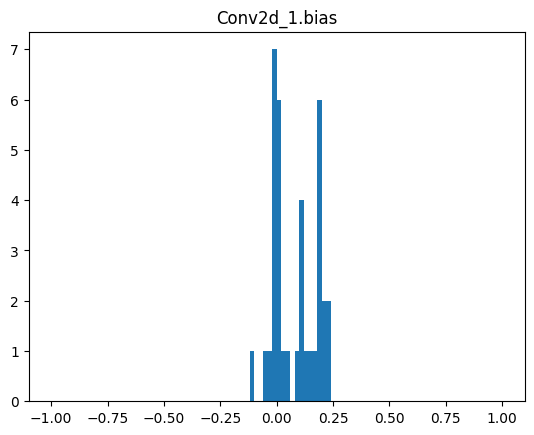

In [101]:
%reload_ext autoreload
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
title = "Conv2d_1.bias"
model.load_state_dict(torch.load('bin/policy2.pth'))
visualize_param(ax, model, "0.weight", title, bins = 100, range = (-1, 1))

In [117]:
import random

def AIvsrandom(policy, Q_value, AI):
    board = Board()             # 盤面を初期化
    while not board.isEnd():
        if board.canPlay():
            if board.player == AI:
                mctree = MCTree(board)
                player = Player(policy, Q_value)
                mctree = player.oneplay(mctree,False)
                board = mctree.current.board
            else:
                choices = board.choices()
                board = random.choice(list(choices.values()))
        else:
            board = board.passPlayer()
    board.show()
    if board.winner() == AI:
        print("AI wins!")
        return 1
    else:
        print("AI loses!")
        return 0

In [126]:
policy = p_net()
policy.load_state_dict(torch.load('bin/policy2_sim.pth'))
Q_value = v_net()
Q_value.load_state_dict(torch.load('bin/Q_value2_sim.pth'))
# 対戦の準備
board = Board()             # 盤面を初期化
win = 0
trial = 1
for i in range(trial):
    board = Board()
    win += AIvsrandom(policy, Q_value, -1)
    win += AIvsrandom(policy, Q_value, 1)
    #print("trial", i)
print(win/trial/2)

C:\Users\ryota\AppData\Local\Temp\ipykernel_25056\578581544.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load('bin/policy2_sim.pth'))
C:\

|xxoxxxoo|
|xoooxxoo|
|xxxooxoo|
|xxxoxxoo|
|xxoxxxoo|
|xxxxxxxo|
|xxxxxxxo|
|xxxxxxxo|
player: o
AI wins!
|xooooooo|
|xoxxoooo|
|xxxoxooo|
|xoxxoxoo|
|xoxxxoxo|
|xxoxoxxx|
|xxooxoox|
|ooooooox|
player: o
AI wins!
1.0


In [49]:
import random

choices = {}
choices[(0,0)] = 1
choices[(0,1)] = 2
choices[(0,2)] = 3
choices[(1,1)] = 4
choices[(1,2)] = 5
l = list(choices.values())
print(random.choice(l))
print(choices)

1
{(0, 0): 1, (0, 1): 2, (0, 2): 3, (1, 1): 4, (1, 2): 5}
